In [1]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import copy
import torch.nn.functional as F

In [2]:
LEARNING_RATE = 1e-6
EPOCHS = 1
BATCH_SIZE = 64

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(( 0.5, ), ( 0.5, ))])

trainset = datasets.MNIST(root='./data', train=True,download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False,download=True, transform=transform)

validset, trainset = torch.utils.data.random_split(trainset, [10000, 50000])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def feature(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        #x = x.view(-1,3*3*64 )
        x = x.view(x.size(0), -1)
        return x
        
    def forward(self, x):
        x = self.feature(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

        

cnn = Net()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
# Misc functions
def computeAccuracy(network, loader):
    match = 0
    total = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(loader):
            preds = network(data)
            match += sum([np.argmax(preds[i]) == labels[i] for i in range(len(preds))])
            total += len(labels)
    return match/total

def get_prediction_labels(network, loader):
    preds_total = []
    targets_total = []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            preds = network(images)
            pred = list(prediction.argmax() for prediction in preds)

            preds_total.append(pred)
            targets_total.append(labels)
    
    return targets_total, preds_total

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best = copy.deepcopy(model)
    best_accuracy = 0

    training_accuracy, train_loss, validation_accuracy, validation_loss = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        for batch_nr, (data, labels) in enumerate(train_loader):
                predictions = model(data)

                loss = criterion(predictions, labels)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

        print(f'\rEpoch {epoch+1}, batch {batch_nr+1}/{len(train_loader)}, loss={loss}', end='')

        train_loss.append(loss)
        training_accuracy.append(computeAccuracy(model, train_loader))

        model.eval()
        validation_accuracy.append(computeAccuracy(model, validation_loader))

        if validation_accuracy[-1] > best_accuracy:
            best = copy.deepcopy(model)
            best_accuracy = validation_accuracy[-1]

        print(f"\nBest model accuracy: {best_accuracy}")
    return best, training_accuracy, validation_accuracy

def test(model, loader):
    test = computeAccuracy(model, loader)
    print('\nFinal results: ' + str(test))
    return test

Epoch 1, batch 782/782, loss=2.2884457111358643
Best model accuracy: 0.09049999713897705

Final results: tensor(0.0917)


<function matplotlib.pyplot.show(close=None, block=None)>

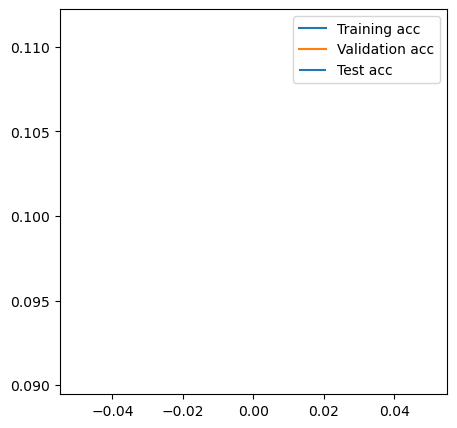

In [7]:

# Load our network
model = Net()

# Define our loss function
criterion = torch.nn.CrossEntropyLoss()

# Define our optimizer, with L^2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Train the model
trained_model, train_accuracy, validation_accuracy = train_model(model, criterion, optimizer, train_loader, validation_loader, EPOCHS)

# Test the model
tested_model = test(trained_model, test_loader)


plt.figure(figsize=(5,5))
plt.plot(train_accuracy, label='Training acc')
plt.plot(validation_accuracy, label='Validation acc')
plt.hlines(tested_model, 0, len(validation_accuracy)-1, label="Test acc")
plt.legend()
plt.show

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [9]:
images, labels = next(iter(train_loader))
f = trained_model.feature(images)

<Axes: >

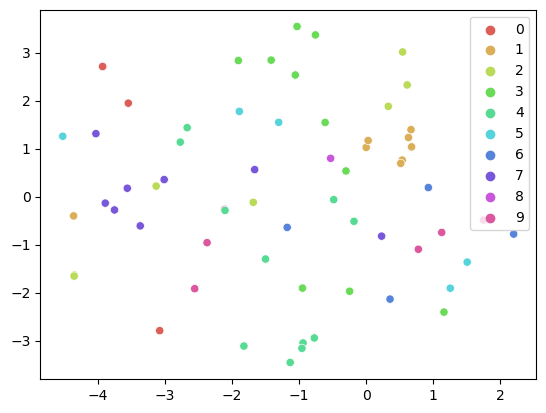

In [22]:
tsne = TSNE(n_components=2,random_state=100)
z = tsne.fit_transform(f.detach().numpy())

y = labels

sns.scatterplot(x=z[:,0],y=z[:,1],hue=y.tolist(), palette= sns.color_palette("hls",10))

<Axes: >

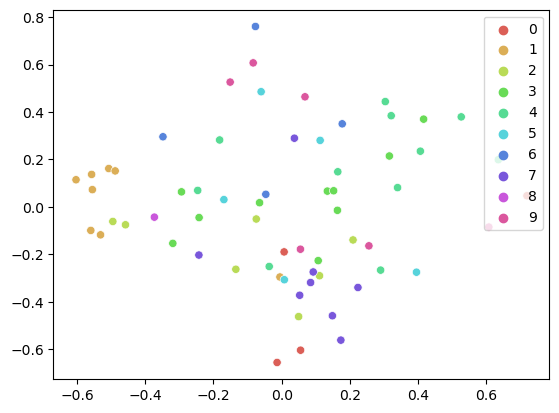

In [24]:
pca = PCA(n_components=2)
p = pca.fit_transform(f.detach().numpy())

y = labels

sns.scatterplot(x=p[:,0],y=p[:,1],hue=y.tolist(), palette= sns.color_palette("hls",10))